# Importing Libraries

In [1]:
import os
import warnings
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma

warnings.filterwarnings("ignore")

load_dotenv()

GROQ_API_KEY = os.getenv("GROQ_API_KEY")
model_name = "deepseek-r1-distill-llama-70b"
# emb_model = "togethercomputer/m2-bert-80M-32k-retrieval"
emb_model = "sentence-transformers/all-mpnet-base-v2"
embedding_function = HuggingFaceEmbeddings(model_name=emb_model)

llm = ChatGroq(
    groq_api_key=GROQ_API_KEY,
    model=model_name,
)

# Input and Output State

In [2]:
from langgraph.graph import END, START, StateGraph
from pydantic import BaseModel
from typing import Optional

class ChatMessages(BaseModel):
    question: str
    answer: Optional[str] = ""
    llm_calls: Optional[int] = 0

In [3]:
def call_model(state: ChatMessages):
    question = state.question
    llm_calls = state.llm_calls
    state.llm_calls = llm_calls + 1
    print(f"llm_calls: {state.llm_calls}")

    response = llm.invoke(question)
    state.answer = response.content
    return state

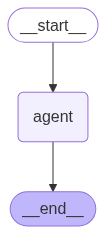

In [4]:
workflow = StateGraph(ChatMessages)

workflow.add_node("agent", call_model)

workflow.add_edge(START, "agent")
workflow.add_edge("agent", END)

graph = workflow.compile()
graph

In [5]:
res = graph.invoke(input={"question": "What is responsible AI"})
res

llm_calls: 1


{'question': 'What is responsible AI',
 'answer': "<think>\nOkay, so I need to understand what Responsible AI is. I've heard the term before, but I'm not entirely sure what it entails. Let me break it down.\n\nFirst, I think AI stands for Artificial Intelligence, right? So Responsible AI must be about using AI in a way that's ethical or considerate. But what does that really mean? Maybe it's about ensuring that AI systems don't harm people or act in ways that aren't fair.\n\nI remember hearing about AI being biased. Like, if the data used to train an AI system is biased, the AI might make unfair decisions. So maybe Responsible AI involves making sure that AI doesn't discriminate against certain groups of people. How would that work? Perhaps by checking the data for biases and trying to eliminate them.\n\nThen there's transparency. I think that means being clear about how AI makes decisions. If an AI decides something important about someone, like whether they get a loan or a job, the p

In [6]:
print(res['answer'])

<think>
Okay, so I need to understand what Responsible AI is. I've heard the term before, but I'm not entirely sure what it entails. Let me break it down.

First, I think AI stands for Artificial Intelligence, right? So Responsible AI must be about using AI in a way that's ethical or considerate. But what does that really mean? Maybe it's about ensuring that AI systems don't harm people or act in ways that aren't fair.

I remember hearing about AI being biased. Like, if the data used to train an AI system is biased, the AI might make unfair decisions. So maybe Responsible AI involves making sure that AI doesn't discriminate against certain groups of people. How would that work? Perhaps by checking the data for biases and trying to eliminate them.

Then there's transparency. I think that means being clear about how AI makes decisions. If an AI decides something important about someone, like whether they get a loan or a job, the person should be able to understand how that decision was m

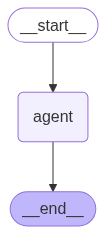

In [7]:
from pydantic import BaseModel, Field

class InputState(BaseModel):
    question: str

class PrivateState(BaseModel):
    llm_calls: int = Field(default=0)

class OutputState(BaseModel):
    answer: Optional[str] = Field(default="")

class OverallState(InputState, PrivateState, OutputState):
    pass



workflow = StateGraph(state_schema=OverallState, input_schema=InputState, output_schema=OutputState)

workflow.add_node("agent", call_model)

workflow.add_edge(START, "agent")
workflow.add_edge("agent", END)


graph = workflow.compile()
graph

In [8]:
res = graph.invoke({"question": "What is responsible AI"})
res

llm_calls: 1


{'answer': '<think>\n\n</think>\n\nResponsible AI refers to the development, deployment, and use of artificial intelligence (AI) in ways that are ethical, transparent, accountable, and beneficial to society. It involves ensuring that AI systems are designed and implemented with consideration for their impact on individuals, communities, and the environment. Key principles of responsible AI include:\n\n1. **Ethical Considerations**: Ensuring that AI systems are aligned with human values and ethical principles, such as fairness, privacy, and respect for human rights.\n\n2. **Transparency and Explainability**: Making AI decision-making processes understandable to users and stakeholders, so that outcomes can be audited and trusted.\n\n3. **Accountability**: Holding developers, deployers, and users of AI systems accountable for their impact, including potential biases, errors, or misuse.\n\n4. **Privacy and Security**: Protecting user data and ensuring that AI systems are secure from misuse

# Add Runtime Configuration

In [10]:
from langgraph.graph import StateGraph, START, END
from langchain_core.runnables.config import RunnableConfig
from langchain.schema import HumanMessage, SystemMessage

def call_model_v2(state: OverallState, config: RunnableConfig):
    language = config['configurable'].get("language", "English")
    system_message_content = f"Respond in {language}"
    system_message = SystemMessage(content=system_message_content)
    messages = [system_message, HumanMessage(content=state.question)]
    response = llm.invoke(messages)
    return {"answer": response}

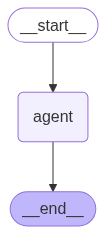

In [11]:
workflow_v2 = StateGraph(state_schema=OverallState, input_schema=InputState, output_schema=OutputState)

workflow_v2.add_node("agent", call_model_v2)

workflow_v2.add_edge(START, "agent")
workflow_v2.add_edge("agent", END)

graph_v2 = workflow_v2.compile()
graph_v2

In [12]:
config = {"configurable": {"language": "Spanish"}}
res1 = graph_v2.invoke({"question": "What is the capital of India"}, config=config)
res1

{'answer': AIMessage(content="<think>\nAlright, so I need to figure out what the capital of India is. I'm not entirely sure, but I think it's a city I've heard before. Let me think... I remember learning something about India's government in school. India is a big country with a rich history, so I guess the capital must be an important city.\n\nI think Delhi is a major city in India. Maybe that's the capital? Or is it Mumbai? Wait, Mumbai is a big city too, but I think it's more known for being a financial hub rather than the capital. Then there's Bangalore, which I believe is more about technology. So, probably not the capital.\n\nI recall that the capital of a country is where the government is centered. India has a federal government, so their capital should be where the parliament and other government buildings are. Delhi sounds familiar in that context. I think I've heard of the Indian Parliament being in Delhi.\n\nAlso, I remember something about New Delhi. Is that a part of Delh

In [15]:
print(res1['answer'].content)

<think>
Alright, so I need to figure out what the capital of India is. I'm not entirely sure, but I think it's a city I've heard before. Let me think... I remember learning something about India's government in school. India is a big country with a rich history, so I guess the capital must be an important city.

I think Delhi is a major city in India. Maybe that's the capital? Or is it Mumbai? Wait, Mumbai is a big city too, but I think it's more known for being a financial hub rather than the capital. Then there's Bangalore, which I believe is more about technology. So, probably not the capital.

I recall that the capital of a country is where the government is centered. India has a federal government, so their capital should be where the parliament and other government buildings are. Delhi sounds familiar in that context. I think I've heard of the Indian Parliament being in Delhi.

Also, I remember something about New Delhi. Is that a part of Delhi or a separate city? Maybe New Delhi

In [16]:
config = {"configurable": {"language": "Kannada"}}
res2 = graph_v2.invoke({"question": "What is the capital of India"}, config=config)
print(res2['answer'].content)

<think>
Okay, the user is asking for the capital of India in Kannada. I need to respond in Kannada as per their instruction. First, I should recall that the capital of India is New Delhi. Now, how do I write that in Kannada? I think it's "ನವ ದೆಹಲಿ." So, I'll make sure to write it correctly. I should also confirm if there are any alternative names or if the spelling has changed, but I believe "ನವ ದೆಹಲಿ" is the standard term used. I should present it clearly and straightforwardly without any additional information since the user specifically asked for a response in Kannada.
</think>

ಭಾರತದ ರಾಜಧಾನಿ ನವ ದೆಹಲಿ.
